In [47]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/tree/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    #print(tgz_path)
    housing_tgz = tarfile.open(tgz_path, 'r:gz')
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    #csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv('housing.csv')

In [48]:
#fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [49]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [50]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [51]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


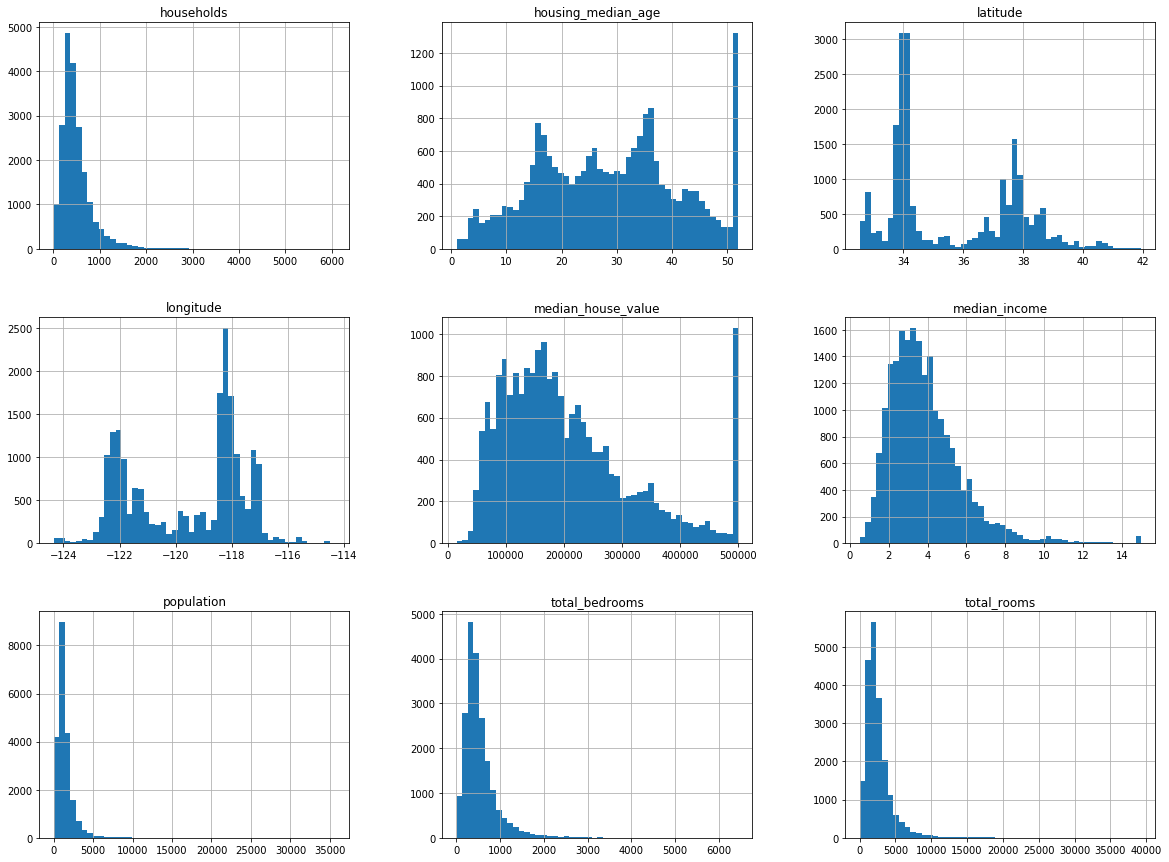

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [53]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [54]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [55]:
import hashlib
hash = hashlib.md5
hash(np.int64(4)).digest()[-1]


18

In [56]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [57]:
# we can easily add an identifier column using reset_index
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [58]:
print(len(train_set), "train + ", len(test_set), "test")

16362 train +  4278 test


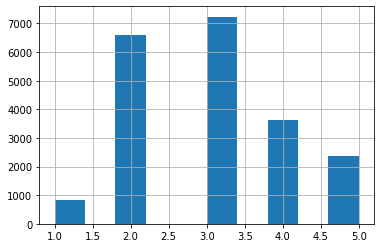

In [59]:
# Trim down the number of income categories by scaling and make a greater-than-5 category
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# drop the temporarily created income_cat column from both sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["income_cat"], axis=1, inplace=True)

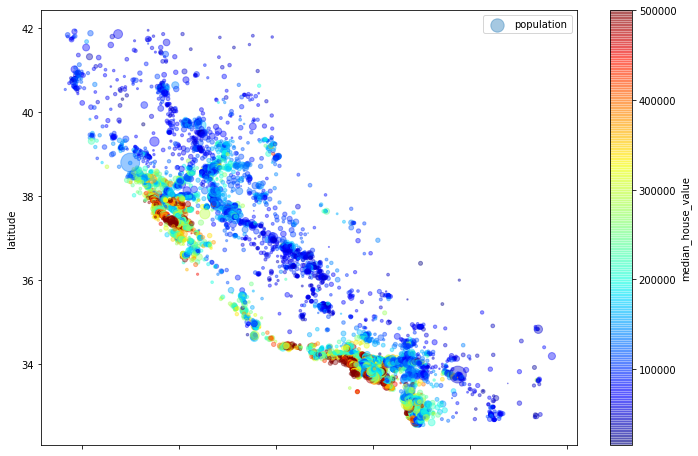

In [61]:
# s is the size and c is the color
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             label="population", c="median_house_value", figsize=(12,8),
             cmap=plt.get_cmap("jet"), colorbar=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000134040ED4C8>,
      dtype=object)

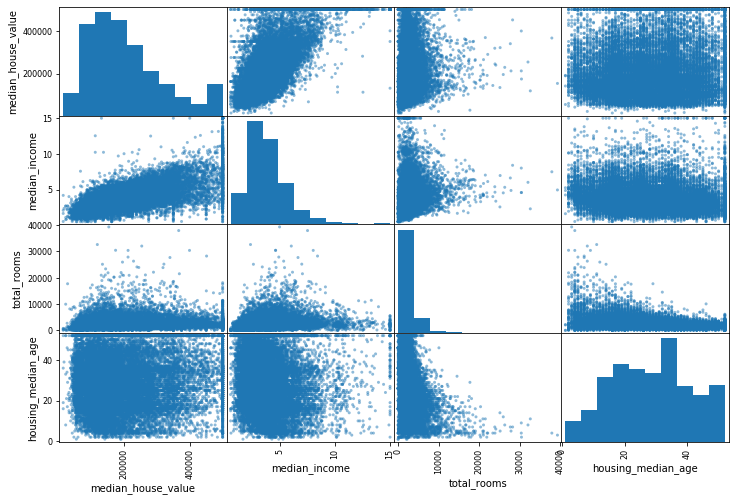

In [62]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# Data Cleaning

# Separate Labels from Predictors


In [63]:
housing = strat_train_set.drop(["median_house_value"], axis=1)
housing_num = housing.drop(["ocean_proximity"], axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Convert Text Categories into a One Hot Vecto

In [64]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
housing_cat_1hot
# i couldn't figure out how to set this array value as a column to the housing dataframe because it provides too many values.

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

# Handle Missing Data with Impute

In [65]:
# Take a look at some rows with missing data
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [66]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


imputer.fit(housing_num)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

# Create a Transformer Class

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

# Create a class, which inherits from TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [68]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_num.values)

In [69]:
housing_extra_attribs

array([[-121.89      ,   37.29      ,   38.        , ...,    2.7042    ,
           4.62536873,    2.09439528],
       [-121.93      ,   37.05      ,   14.        , ...,    6.4214    ,
           6.00884956,    2.7079646 ],
       [-117.2       ,   32.77      ,   31.        , ...,    2.8621    ,
           4.22510823,    2.02597403],
       ...,
       [-116.4       ,   34.09      ,    9.        , ...,    3.2723    ,
           6.34640523,    2.74248366],
       [-118.01      ,   33.82      ,   31.        , ...,    4.0625    ,
           5.50561798,    3.80898876],
       [-122.45      ,   37.77      ,   52.        , ...,    3.575     ,
           4.84350548,    1.98591549]])

# Create a Pipeline

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Our DataFrameSelector will select the columns from a pandas dataframe
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
   
 # LabelBinarizer changed to support only encoding labels (y)
 # not datasets (X) so these days it takes only X not 
 # X AND y so this custom class is a hack for that.
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)
    
cat_attribs = ["ocean_proximity"]
num_attribs = list(housing.drop(cat_attribs, axis=1))

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer',  SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
# we have a separate pipeline for the categorical columns
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', CustomLabelBinarizer()),
        ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

In [71]:
housing_prepared = full_pipeline.fit_transform(housing)

In [72]:
housing_prepared.shape

(16512, 16)

# Select and Train Your Model

# A Linear Regression Model

In [73]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = housing_prepared[:5]
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44794413,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.1349975 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.03960649,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.78819259,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15576519,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.38346663,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39924764,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19250256,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [75]:
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210944.00355933 318525.57377201 210996.32843857  60049.49209858
 191123.83671223]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [76]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68727.62070058881

# Cross Validated Regression Tree

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#scikit0learn cross val expects utilty function
#(Greater is better) rather than cost function (lower better)
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70150.26912902 67247.6665008  70803.51567299 70714.55499392
 70136.12837457 73575.91687965 71119.67532672 70549.79170282
 75708.56784236 70548.04441638]
Mean: 71055.41308392196
Standard deviation: 2118.134431813173


# Compare to Lin Reg Scores

In [78]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66991.93077833 67048.67926539 70444.05577272 74774.02214626
 68102.64264448 71319.00743013 65085.0968163  68353.36278098
 71773.08099554 67789.05273148]
Mean: 69168.0931361612
Standard deviation: 2721.5086664298246


# Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49254.26915634 47577.45747564 50002.40289223 52063.06790651
 49812.12307456 53280.47887478 49021.5480322  47760.27998754
 52734.72227832 50333.01163472]
Mean: 50183.936131283466
Standard deviation: 1862.871782845688


# Support Vector Machine

In [80]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [111390.69128357 119541.55515113 116957.96388117 120448.27554532
 117616.12896308 122311.2177119  117633.89605002 121468.53342283
 120344.34254306 118015.98960411]
Mean: 118572.85941561937
Standard deviation: 2936.877189765709


# Grid Search to Identify the Best Hyperparameters

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [82]:
# The best hyperparameter combination found:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [83]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [84]:
# Let's look at the score of each hyperparameter combination tested during the grid search:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64702.215800988604 {'max_features': 2, 'n_estimators': 3}
55696.841908085655 {'max_features': 2, 'n_estimators': 10}
53048.44673570149 {'max_features': 2, 'n_estimators': 30}
59889.62452462564 {'max_features': 4, 'n_estimators': 3}
52596.85255755284 {'max_features': 4, 'n_estimators': 10}
50339.02229420867 {'max_features': 4, 'n_estimators': 30}
58064.341017584295 {'max_features': 6, 'n_estimators': 3}
51792.604028197245 {'max_features': 6, 'n_estimators': 10}
50075.19485796658 {'max_features': 6, 'n_estimators': 30}
58758.165300837696 {'max_features': 8, 'n_estimators': 3}
52533.61146832657 {'max_features': 8, 'n_estimators': 10}
49919.18504528282 {'max_features': 8, 'n_estimators': 30}
63628.91817397355 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54962.37226662787 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59750.88280487604 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52736.322388958884 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [85]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.138195,0.011953,0.006799,0.000750,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.019079e+09,-4.468544e+09,-4.152370e+09,-4.149139e+09,-4.142752e+09,-4.186377e+09,1.497020e+08,18
1,0.711356,0.146793,0.023400,0.005953,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.931151e+09,-3.267380e+09,-3.179426e+09,-2.904489e+09,-3.228245e+09,-3.102138e+09,1.532861e+08,11
2,1.454179,0.168931,0.048808,0.004036,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.628570e+09,-2.933274e+09,-2.923677e+09,-2.647485e+09,-2.937683e+09,-2.814138e+09,1.439891e+08,9
3,0.217377,0.014082,0.006812,0.000406,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.445333e+09,-3.802746e+09,-3.898979e+09,-3.348510e+09,-3.438268e+09,-3.586767e+09,2.204290e+08,16
4,0.830548,0.228670,0.019600,0.003878,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.588100e+09,-2.864173e+09,-2.967580e+09,-2.569940e+09,-2.842353e+09,-2.766429e+09,1.588642e+08,7
5,2.031076,0.120019,0.053198,0.013525,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.355497e+09,-2.598594e+09,-2.719732e+09,-2.370292e+09,-2.625970e+09,-2.534017e+09,1.454582e+08,3
6,0.252984,0.004774,0.006201,0.000401,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.313650e+09,-3.288207e+09,-3.549699e+09,-3.348816e+09,-3.356967e+09,-3.371468e+09,9.248231e+07,13
7,1.095533,0.217718,0.019399,0.005570,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.571659e+09,-2.656095e+09,-2.938962e+09,-2.497515e+09,-2.748138e+09,-2.682474e+09,1.531557e+08,5
8,3.415590,0.898667,0.053398,0.013002,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.388743e+09,-2.538947e+09,-2.648860e+09,-2.351816e+09,-2.609259e+09,-2.507525e+09,1.180400e+08,2
9,0.368376,0.074440,0.007000,0.001549,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.260369e+09,-3.721093e+09,-3.567057e+09,-3.133807e+09,-3.580285e+09,-3.452522e+09,2.191228e+08,14


In [86]:
from sklearn.externals import joblib
joblib.dump(SVR,"Housing.pkl")

['Housing.pkl']